In [1]:
run_gridsearch = True
skip_best_model_validation = False
skip_best_model_test = False
verbose = False
GPU_SETTING = -1
NUM_ENSEMBLES = 5
BASIN = "calpella"
MODE = "daily"
RUN_LABEL = "TEST"
READ_STAMP = None

In [2]:
hyperparam_space = {
    "hidden_size": [64],
    "seq_length": [90],
    "num_layers": [1],
    "epochs": [1,2],
    "batch_size": [64],
    "schedule_pairs": [
        ((0.5, 0.25), (0.01, 0.005, 0.001))
    ]
}

In [3]:
import sys
import pandas as pd
import os
import itertools
from pathlib import Path
from tqdm import tqdm
import warnings
from datetime import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
current_dir = os.getcwd()
print(current_dir)

/Users/canruso/Desktop/UCB-USACE-LSTMs/notebooks/basins/calpella


In [5]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)
print(sys.path)

['../../../../UCB-USACE-LSTMs', '/Users/canruso/Desktop/UCB-USACE-LSTMs/notebooks/basins/calpella', '/Users/canruso/Desktop', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python310.zip', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/lib-dynload', '', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/setuptools/_vendor']


In [6]:
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (fractional_multi_lr, write_paths, to_path_or_list, ensure_output_tree, set_active_context, data_dir, repo_root, get_output_dir, make_run_stamp, get_yaml_path, ctx_for, hparams_exists, save_hparams, load_hparams, runs_latest_path, archive_runs_json, read_csv_artifact, ensure_shared_tree)
from UCB_training.UCB_plotting import (plot_timeseries_comparison, scatter_triptych_pngs_v3, ts_triptych_v3)

In [7]:
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

In [8]:
RUNS_FILE = str(runs_latest_path(BASIN, MODE, RUN_LABEL))
SHOULD_STAMP = not (skip_best_model_validation and skip_best_model_test)
RUN_STAMP = make_run_stamp() if SHOULD_STAMP else None

In [9]:
set_active_context(basin=BASIN, resolution=MODE, run_stamp=RUN_STAMP, run_tag=RUN_LABEL, append_stamp_to_filenames=False)
SHARED_FOLDER = ensure_shared_tree(BASIN, MODE)
RUNS_PARENT = SHARED_FOLDER / "runs" / (f"{RUN_LABEL}_{RUN_STAMP}" if RUN_STAMP else RUN_LABEL)

print("NH runs will be written under:")
print(RUNS_PARENT.resolve())

NH runs will be written under:
/Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/calpella/daily_shared/runs/TEST_20250828T081349Z


In [10]:
path_to_csv = data_dir()
path_to_yaml = get_yaml_path("calpella_gage_nlayer")
path_to_physics_data =path_to_csv / "Calpella_daily_shift.csv"

In [11]:
features_with_physics = [
    #from hourly
    "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "EF RUSSIAN 20 PRECIP-INC SCREENED",
    "POTTER VALLEY CA FLOW USGS_ADJUSTED",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    #from new capella.csv
    'Capella Gage FLOW',
    'EF Russian 20 ET-POTENTIAL',
    'EF Russian 20 FLOW',
    'EF Russian 20 FLOW-BASE',
    'EF Russian 20 INFILTRATION',
    'EF Russian 20 PERC-SOIL',
    'EF Russian 20 SATURATION FRACTION',
    #    'Lake Mendocino Storage',
]

In [12]:
no_physics_results = []
physics_results = []

In [13]:
start_time = datetime.utcnow()
print("Start time:", start_time.strftime("%Y-%m-%d %H:%M:%S"))

Start time: 2025-08-28 08:13:49


In [14]:
print("repo_root used by UCB_training:", repo_root())

hp_dir = ensure_shared_tree(BASIN, MODE) / "hyperparameters"
hp_file = hp_dir / f"{BASIN}_{MODE}_{RUN_LABEL}_hyperparams.csv"
print("Expecting hyperparams file at:", hp_file)
print("Exists?", hp_file.exists())

print("BASIN/MODE/LABEL:", repr(BASIN), repr(MODE), repr(RUN_LABEL))
print("hparams_exists? ->", hparams_exists(BASIN, MODE, RUN_LABEL))

repo_root used by UCB_training: /Users/canruso/Desktop/UCB-USACE-LSTMs
Expecting hyperparams file at: /Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/calpella/daily_shared/hyperparameters/calpella_daily_TEST_hyperparams.csv
Exists? False
BASIN/MODE/LABEL: 'calpella' 'daily' 'TEST'
hparams_exists? -> True


In [15]:
hyperparam_names = []
for i, hp in enumerate(hyperparam_space.keys()):
    hyperparam_names.append(hp)

total_iters = 1
for name in hyperparam_names:
    total_iters *= len(hyperparam_space[name])

if run_gridsearch or not hparams_exists(BASIN, MODE, RUN_LABEL):
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):

        hp_run = {}
        j = 0
        schedule_pairs = None
        
        while j < len(hyperparam_names):
            name = hyperparam_names[j]
            val = combinations[j]

            if name == "seq_length":
                hp_run["seq_length"] = val

            elif name == "schedule_pairs":
                schedule_pairs = val
            else:
                hp_run[name] = val

            j += 1

        if schedule_pairs is not None:
            fractions, rates = schedule_pairs
            hp_run["learning_rate"] = fractional_multi_lr(
                epochs=int(hp_run["epochs"]), fractions=list(fractions), lrs=list(rates))
        else:
            hp_run.setdefault("learning_rate", {0: 0.01, 30: 0.005, 40: 0.001})

        if verbose:
            print(f"\nNoPhysics: {hp_run}")
            
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=False,  
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
            runs_parent=RUNS_PARENT,
            run_label=RUN_LABEL,
            run_stamp=RUN_STAMP)
        
        trainer.train()
        csv_path, metrics_dict = trainer.results()
        
        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] == "learning_rate":
                row_data["learning_rate"] = str(hp_run["learning_rate"])
            else:
                row_data[hyperparam_names[j]] = combinations[j]
            j += 1
            
        for k, v in metrics_dict.items():
            row_data[k] = v
        
        no_physics_results.append(row_data)

    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping grid search!")

Grid-Search: 100%|############| 2/2 [00:06<00:00,  3.12s/it]


In [16]:
if run_gridsearch or not hparams_exists(BASIN, MODE, RUN_LABEL):   
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):

        hp_run = {}
        j = 0
        schedule_pairs = None
        
        while j < len(hyperparam_names):
            name = hyperparam_names[j]
            val  = combinations[j]

            if name == "seq_length":
                hp_run["seq_length"] = val

            elif name == "schedule_pairs":
                schedule_pairs = val

            else:
                hp_run[name] = val

            j += 1

        if schedule_pairs is not None:
            fractions, rates = schedule_pairs
            hp_run["learning_rate"] = fractional_multi_lr(
                epochs=int(hp_run["epochs"]), fractions=list(fractions), lrs=list(rates))
        else:
            hp_run.setdefault("learning_rate", {0: 0.01, 30: 0.005, 40: 0.001})
            
        if verbose:
            print(f"\nPhysics: {hp_run}")
            
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data,
            hourly=False,
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
            runs_parent=RUNS_PARENT,
            run_label=RUN_LABEL,
            run_stamp=RUN_STAMP)
        
        trainer.train()
        csv_path, metrics_dict = trainer.results()

        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] == "learning_rate":
                row_data["learning_rate"] = str(hp_run["learning_rate"])
            else:
                row_data[hyperparam_names[j]] = combinations[j]
            j += 1

        for k, v in metrics_dict.items():
            row_data[k] = v
            
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    save_hparams(best_df=best_params_df, basin=BASIN, mode=MODE, label=RUN_LABEL, run_stamp=RUN_STAMP, df_no=df_no_physics, df_phys=df_physics)
else:
    print("Skipping grid search!")

Grid-Search: 100%|############| 2/2 [00:04<00:00,  2.27s/it]


In [17]:
try:
    best_params_df = load_hparams(BASIN, MODE, RUN_LABEL)
except FileNotFoundError as e:
    raise SystemExit(f"[ERROR] {e}  (Set run_gridsearch=True to generate it.)")
    
best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()
best_no_physics_params = {}

j = 0
while j < len(hyperparam_names):
    
    if hyperparam_names[j] == "output_dropout":
        best_no_physics_params[hyperparam_names[j]] = float(best_no_phys[hyperparam_names[j]])
        j += 1
        
    elif hyperparam_names[j] == "learning_rate":
        best_no_physics_params["learning_rate"] = eval(best_no_phys["learning_rate"])
        j += 1

    elif hyperparam_names[j] == "seq_length":
        best_no_physics_params["seq_length"] = int(best_no_phys["seq_length"])
        j += 1
        
    elif hyperparam_names[j] == "schedule_pairs":
        j += 1
        continue
        
    else:
        best_no_physics_params[hyperparam_names[j]] = int(best_no_phys[hyperparam_names[j]])
        j += 1

best_physics_params = {}
j = 0
while j < len(hyperparam_names):
    
    if hyperparam_names[j] == "output_dropout":
        best_physics_params[hyperparam_names[j]] = float(best_phys[hyperparam_names[j]])
        j += 1
        
    elif hyperparam_names[j] == "learning_rate":
        best_physics_params["learning_rate"] = eval(best_phys["learning_rate"])
        j += 1
    
    elif hyperparam_names[j] == "schedule_pairs":
        j += 1
        continue

    elif hyperparam_names[j] == "seq_length":
        best_physics_params["seq_length"] = int(best_phys["seq_length"])
        j += 1
        
    else:
        best_physics_params[hyperparam_names[j]] = int(best_phys[hyperparam_names[j]])
        j += 1

print("Loaded best hyperparams from CSV:")
print("Best NO-PHYS:", best_no_physics_params)
print("Best PHYS:", best_physics_params)

Loaded best hyperparams from CSV:
Best NO-PHYS: {'hidden_size': 64, 'seq_length': 90, 'num_layers': 1, 'epochs': 2, 'batch_size': 64}
Best PHYS: {'hidden_size': 64, 'seq_length': 90, 'num_layers': 1, 'epochs': 2, 'batch_size': 64}


### Re-run validation with best hyperparameters

In [18]:
if not skip_best_model_validation:
    lstmNoPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmNoPhysicsValBest.train()
    no_physics_val_csv, no_physics_val_metrics = lstmNoPhysicsValBest.results()
    no_physics_val_metrics

[DEBUG:_create_ensemble] => Starting function with frequencies: ['1D']


100%|██████████| 1/1 [00:00<00:00, 137.91it/s]


In [19]:
if not skip_best_model_validation:
    lstmPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmPhysicsValBest.train()
    physics_val_csv, physics_val_metrics = lstmPhysicsValBest.results()
    physics_val_metrics

[DEBUG:_create_ensemble] => Starting function with frequencies: ['1D']


100%|██████████| 1/1 [00:00<00:00, 137.57it/s]


HMS
  NSE = 0.749
  PBIAS = -4.556
LSTM
  NSE = 0.754
  PBIAS = -1.269
PILSTM
  NSE = 0.788
  PBIAS = 6.312


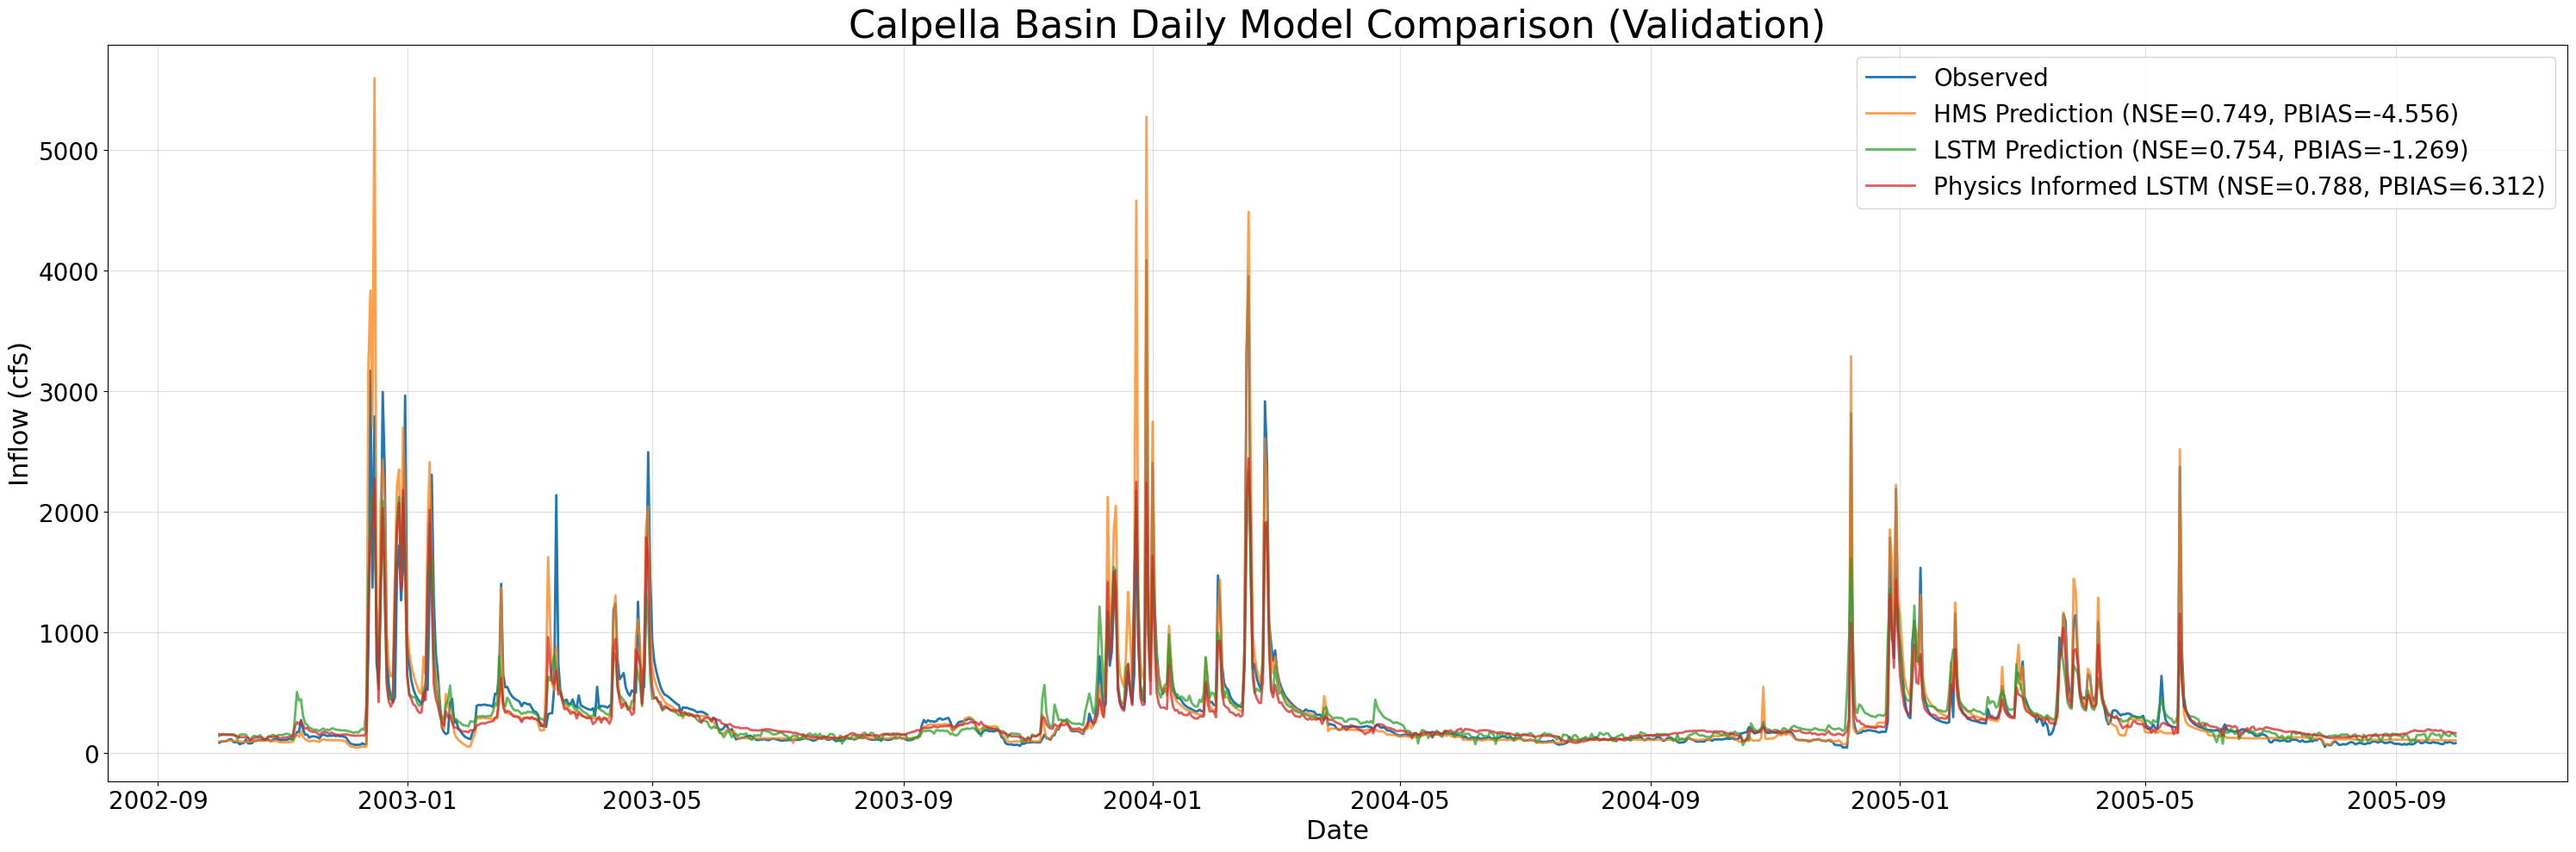

In [20]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Calpella Basin Daily Model Comparison (Validation)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_val_metrics.csv", ts_out="calpella_daily_val_combined_ts.csv", fig_out="calpella_daily_val_model_comparison.png", legend_font=20, axis_font=22)
else:
    combined_df_val = read_csv_artifact("calpella_daily_val_combined_ts.csv", kind="csv", period="validation", stamp = READ_STAMP, run_label = RUN_LABEL)
    plot_timeseries_comparison(source=combined_df_val, title="Calpella Basin Daily Model Comparison (Validation)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_val_metrics.csv", ts_out="calpella_daily_val_combined_ts.csv", fig_out="calpella_daily_val_model_comparison.png", legend_font=20, axis_font=22)

In [21]:
if skip_best_model_validation:
    val_metrics = read_csv_artifact("calpella_daily_val_metrics.csv", kind="metrics", period="validation", index_col=0, stamp = READ_STAMP, run_label = RUN_LABEL)
    print(val_metrics)

### Re-run testing with best hyperparameters

In [22]:
if not skip_best_model_test:
    lstmNoPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=True,  
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmNoPhysicsExtBest.train()
    no_physics_test_csv, no_physics_test_metrics = lstmNoPhysicsExtBest.results('test')
    no_physics_test_metrics

[DEBUG:_create_ensemble] => Starting function with frequencies: ['1D']


100%|██████████| 1/1 [00:00<00:00, 148.32it/s]


In [23]:
if not skip_best_model_test:
    lstmPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=True,
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmPhysicsExtBest.train()
    physics_test_csv, physics_test_metrics = lstmPhysicsExtBest.results('test')
    physics_test_metrics

[DEBUG:_create_ensemble] => Starting function with frequencies: ['1D']


100%|██████████| 1/1 [00:00<00:00, 154.68it/s]


HMS
  NSE = 0.699
  PBIAS = -5.886
LSTM
  NSE = 0.688
  PBIAS = 7.423
PILSTM
  NSE = 0.742
  PBIAS = 1.527


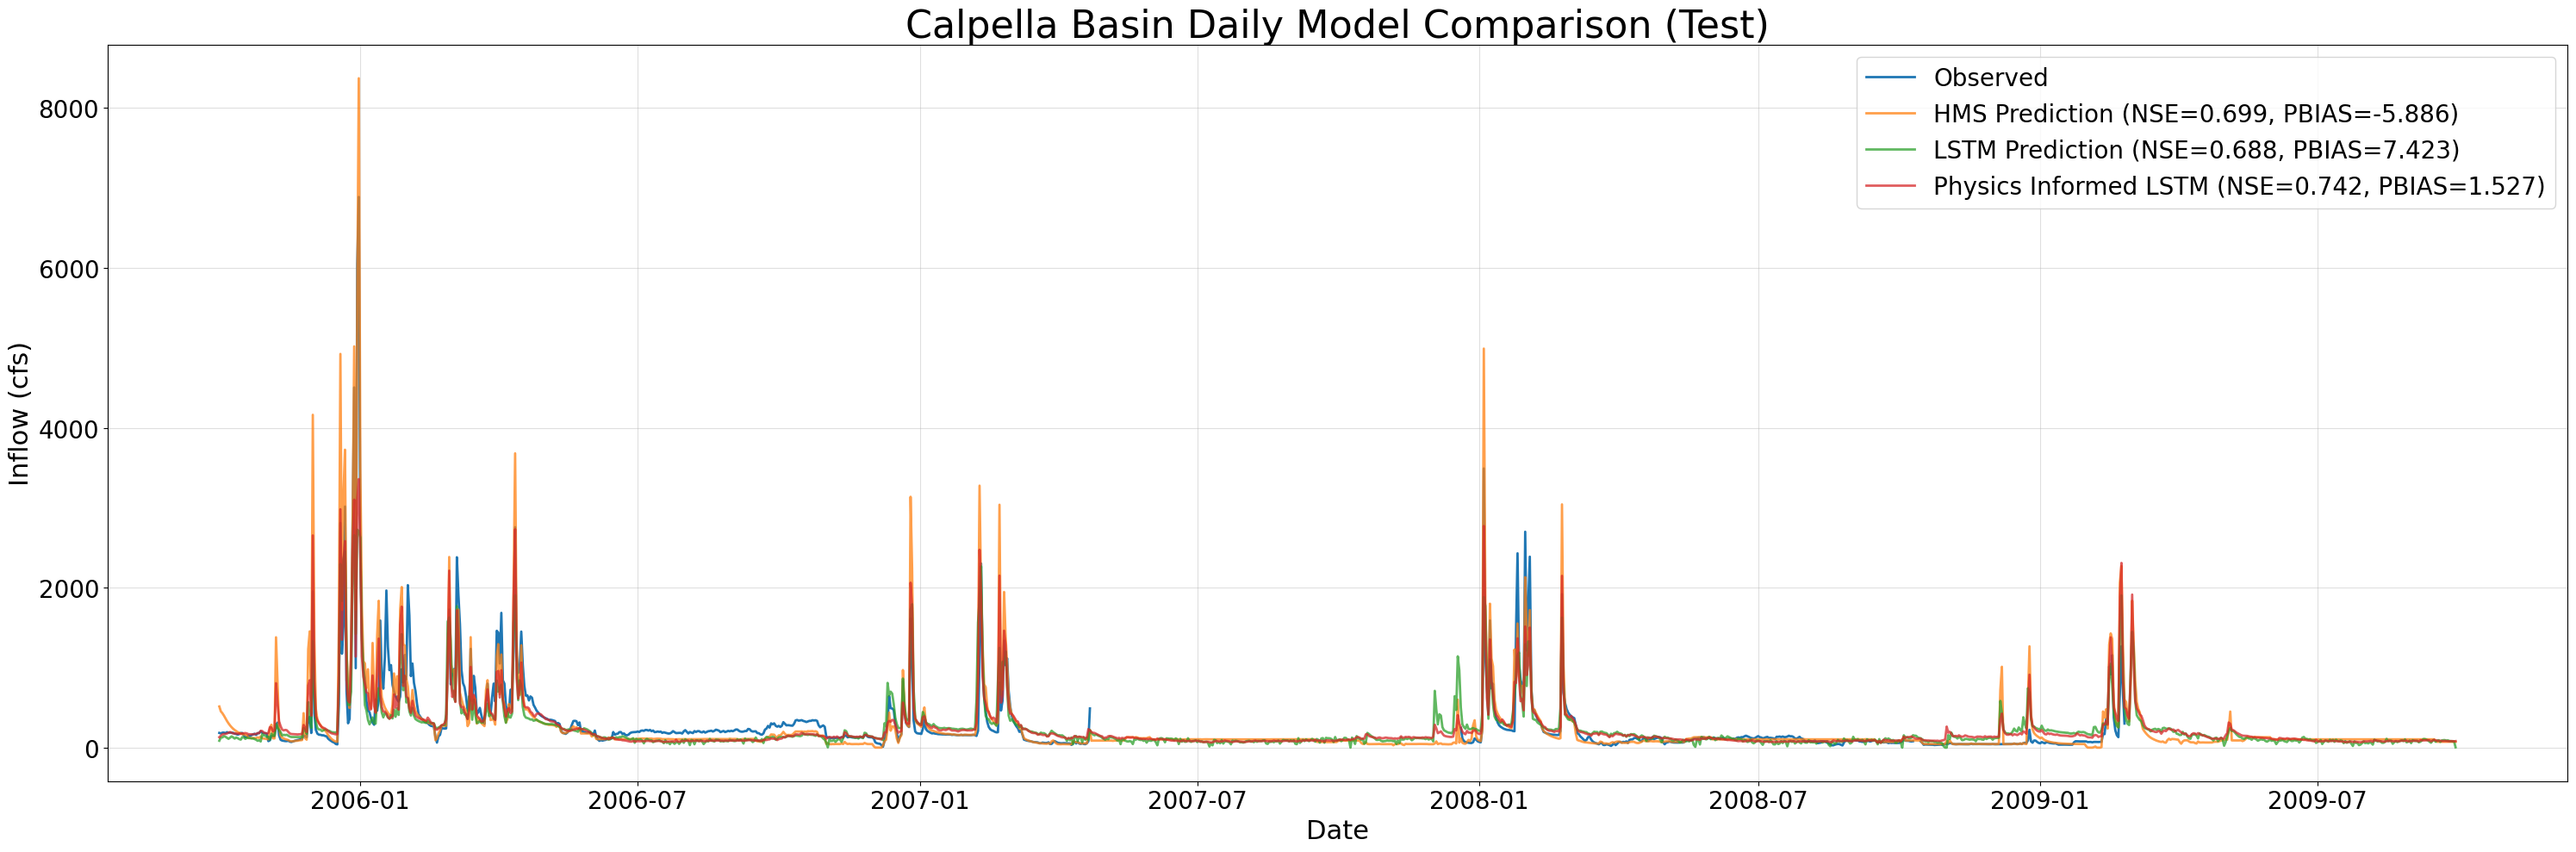

In [24]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Basin Daily Model Comparison (Test)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=20, axis_font=22)
else:
    combined_df = read_csv_artifact("calpella_daily_test_combined_ts.csv", kind="csv", period="test", stamp = READ_STAMP, run_label = RUN_LABEL)
    plot_timeseries_comparison(source=combined_df, title="Calpella Basin Daily Model Comparison (Test)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=20, axis_font=22)

In [25]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Basin Daily Model Comparison (Test)", backend="plotly", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Basin Daily Model Comparison (Test)", backend="plotly", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=12, axis_font=22)

HMS
  NSE = 0.699
  PBIAS = -5.886
LSTM
  NSE = 0.688
  PBIAS = 7.423
PILSTM
  NSE = 0.742
  PBIAS = 1.527


In [26]:
test_metrics = read_csv_artifact("calpella_daily_test_metrics.csv", kind="metrics", period="test", index_col=0, stamp = READ_STAMP, run_label = RUN_LABEL)
print(test_metrics)

                      HMS          LSTM        PILSTM
NSE              0.699185      0.687819      0.742214
MSE          76611.391217  79506.269057  65652.877988
RMSE           276.787628    281.968560    256.228176
KGE              0.746423      0.650907      0.751580
Alpha-NSE        1.224704      0.697027      0.792288
Beta-KGE         1.058860      0.925774      0.984726
Beta-NSE         0.034578     -0.043604     -0.008973
Pearson-r        0.898291      0.843272      0.864594
FHV             25.593699    -28.310212    -15.482757
FMS              0.630349    -19.822853    -16.457698
FLV           -969.540579   -994.156985     77.159513
Peak-Timing      0.000000      0.500000      0.000000
Peak-MAPE       54.234115     38.919061     36.508521
PBIAS           -5.886041      7.422589      1.527389


In [27]:
if not skip_best_model_test:
    write_paths("no_physics", lstmNoPhysicsExtBest, filename = RUNS_FILE)
    write_paths("physics", lstmPhysicsExtBest, filename = RUNS_FILE)
    archived_path = archive_runs_json(Path(RUNS_FILE), BASIN, MODE, RUN_LABEL, RUN_STAMP)

stored paths for 'no_physics' in calpella_daily_TEST_stored_runs.json: ['/Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/calpella/daily_shared/runs/TEST_20250828T081349Z/testing_run/testing_run_2808_111437', '/Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/calpella/daily_shared/runs/TEST_20250828T081349Z/testing_run/testing_run_2808_111437/testing_run_2808_111440', '/Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/calpella/daily_shared/runs/TEST_20250828T081349Z/testing_run/testing_run_2808_111437/testing_run_2808_111440/testing_run_2808_111443', '/Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/calpella/daily_shared/runs/TEST_20250828T081349Z/testing_run/testing_run_2808_111437/testing_run_2808_111440/testing_run_2808_111443/testing_run_2808_111446', '/Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/calpella/daily_shared/runs/TEST_20250828T081349Z/testing_run/testing_run_2808_111437/testing_run_2808_111440/testing_run_2808_111443/testing_run_2808_111446/testing_run_2808_111449']
stored paths 

In [28]:
end_time = datetime.utcnow()
print("\nEnd time:", end_time.strftime("%Y-%m-%d %H:%M:%S"))
print("Total time:", end_time - start_time)


End time: 2025-08-28 08:15:22
Total time: 0:01:33.451611


##### Additional Plots

In [29]:
if skip_best_model_validation:
    combined_df_val = read_csv_artifact("calpella_daily_val_combined_ts.csv", kind="csv", period="validation", stamp = READ_STAMP, run_label = RUN_LABEL)
if skip_best_model_test:
    combined_df = read_csv_artifact("calpella_daily_test_combined_ts.csv", kind="csv", period="test", stamp = READ_STAMP, run_label = RUN_LABEL)

In [30]:
metric_list = ["NSE", "PBIAS"]

wettest_start_val = "2003-10-01"
wettest_end_val = "2004-09-30"
dryest_start_val = "2004-10-01"
dryest_end_val = "2005-09-30"
wettest_start_test = "2005-10-01"
wettest_end_test = "2006-09-30"
dryest_start_test = "2008-10-01"
dryest_end_test = "2009-09-30"

HMS
  NSE = 0.749
  PBIAS = -4.556
LSTM
  NSE = 0.754
  PBIAS = -1.269
PILSTM
  NSE = 0.788
  PBIAS = 6.312


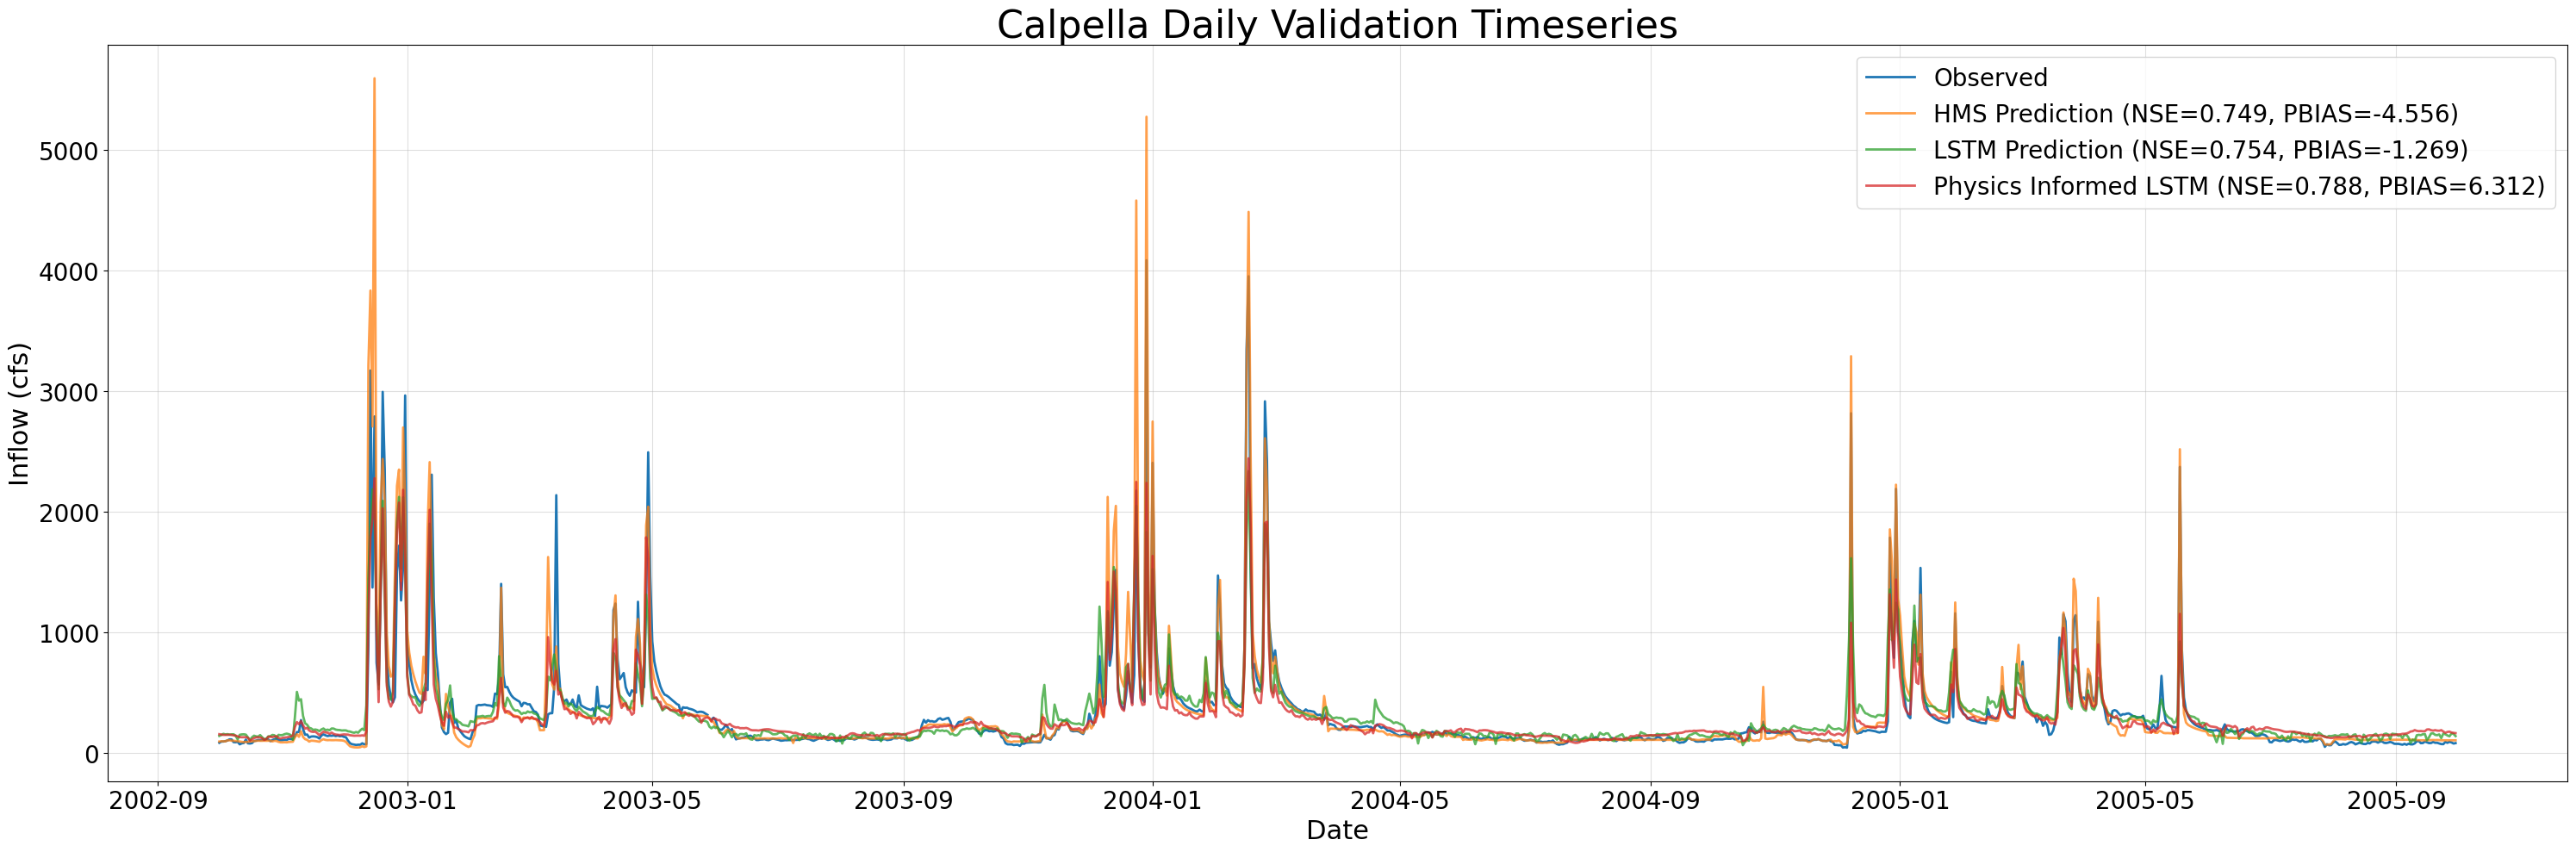

In [31]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Calpella Daily Validation Timeseries", backend="mpl", metrics=metric_list, metrics_out="calpella_daily_val_metrics.csv", ts_out="calpella_daily_val_combined_ts.csv", fig_out="calpella_daily_val_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Calpella Daily Validation Timeseries", backend="mpl", metrics=metric_list, metrics_out="calpella_daily_val_metrics.csv", ts_out="calpella_daily_val_combined_ts.csv", fig_out="calpella_daily_val_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.699
  PBIAS = -5.886
LSTM
  NSE = 0.688
  PBIAS = 7.423
PILSTM
  NSE = 0.742
  PBIAS = 1.527


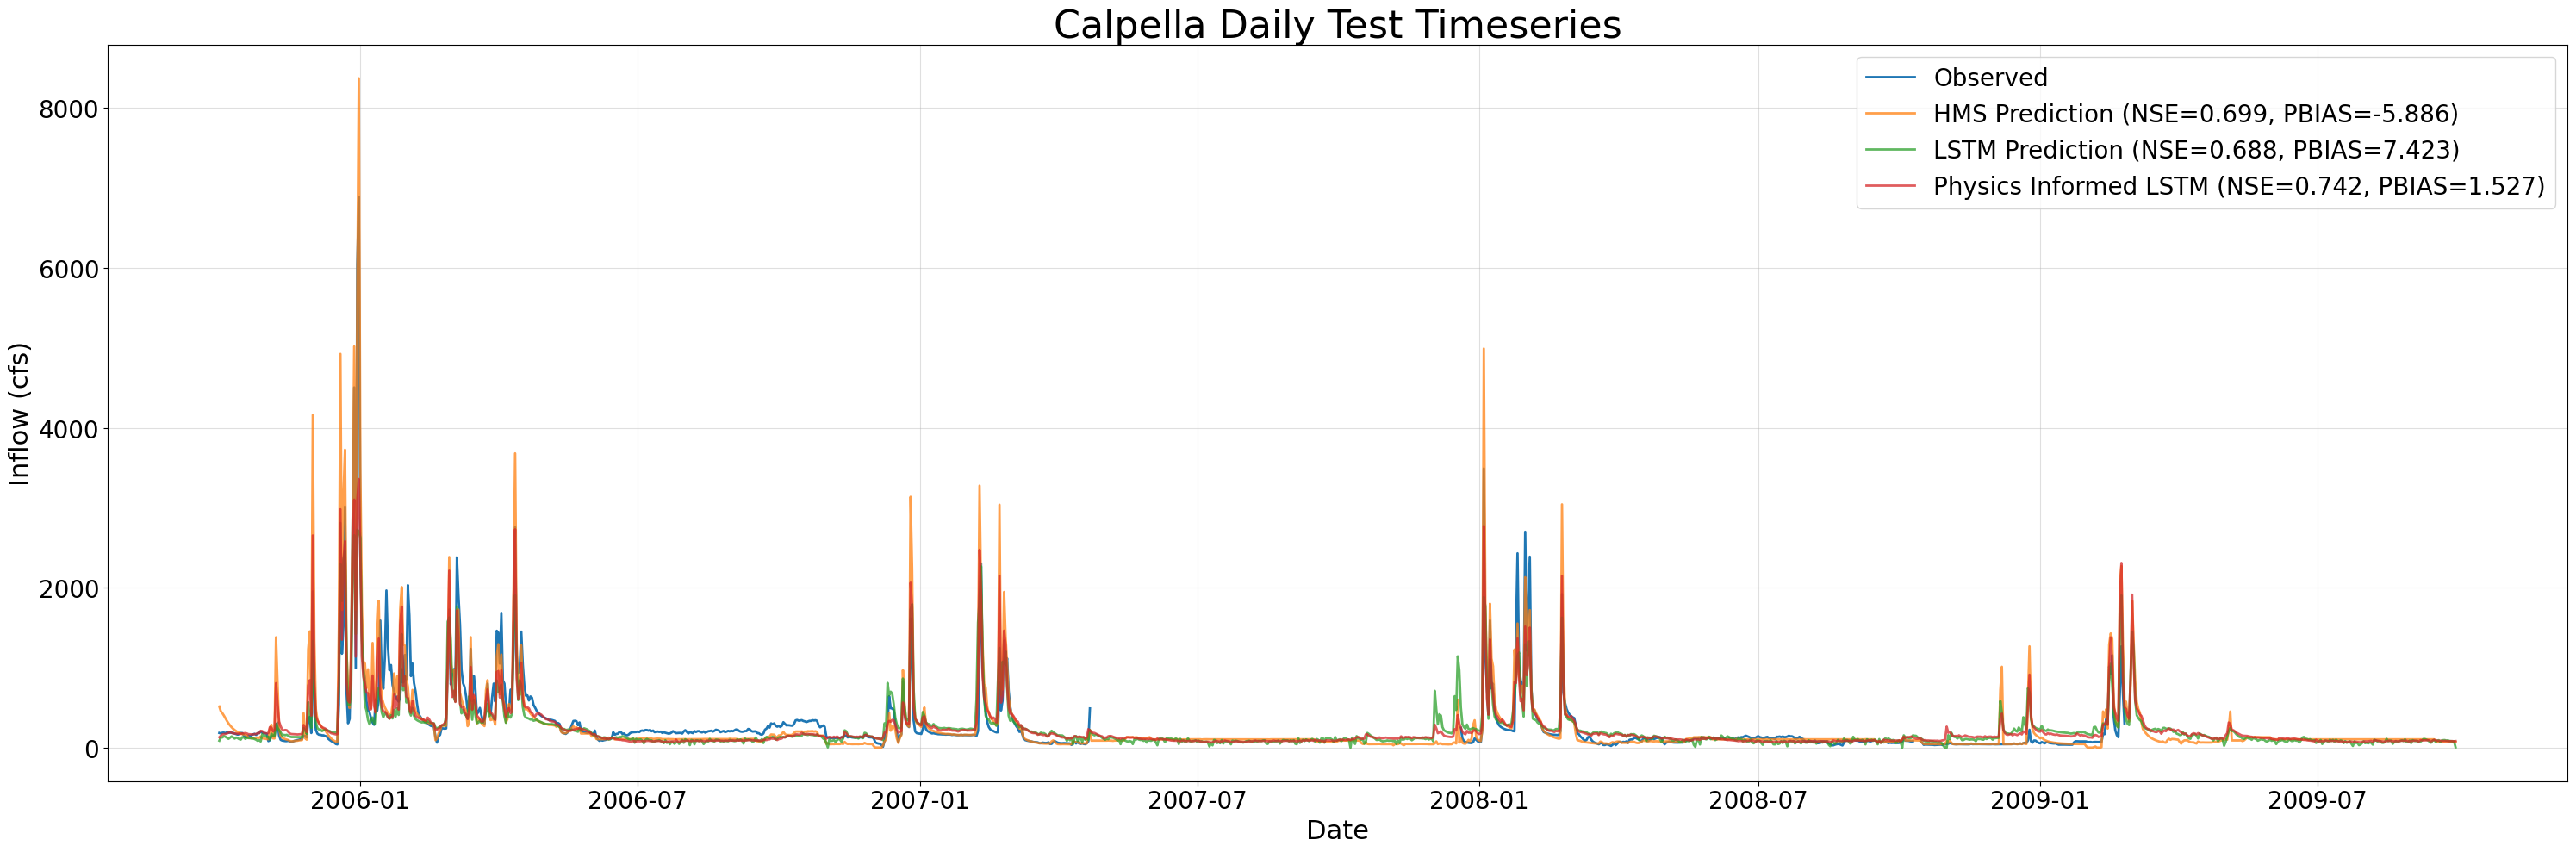

In [32]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Test Timeseries", backend="mpl", metrics=metric_list, metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Test Timeseries", backend="mpl", metrics=metric_list, metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=20, axis_font=22)

In [33]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Test Timeseries – Interactive", backend="plotly", metrics=metric_list, metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Timeseries – Interactive", backend="plotly", metrics=metric_list, metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = 0.699
  PBIAS = -5.886
LSTM
  NSE = 0.688
  PBIAS = 7.423
PILSTM
  NSE = 0.742
  PBIAS = 1.527


### Wettest Year Performance

HMS
  NSE = 0.833
  PBIAS = -8.424
LSTM
  NSE = 0.792
  PBIAS = -3.233
PILSTM
  NSE = 0.839
  PBIAS = 7.556


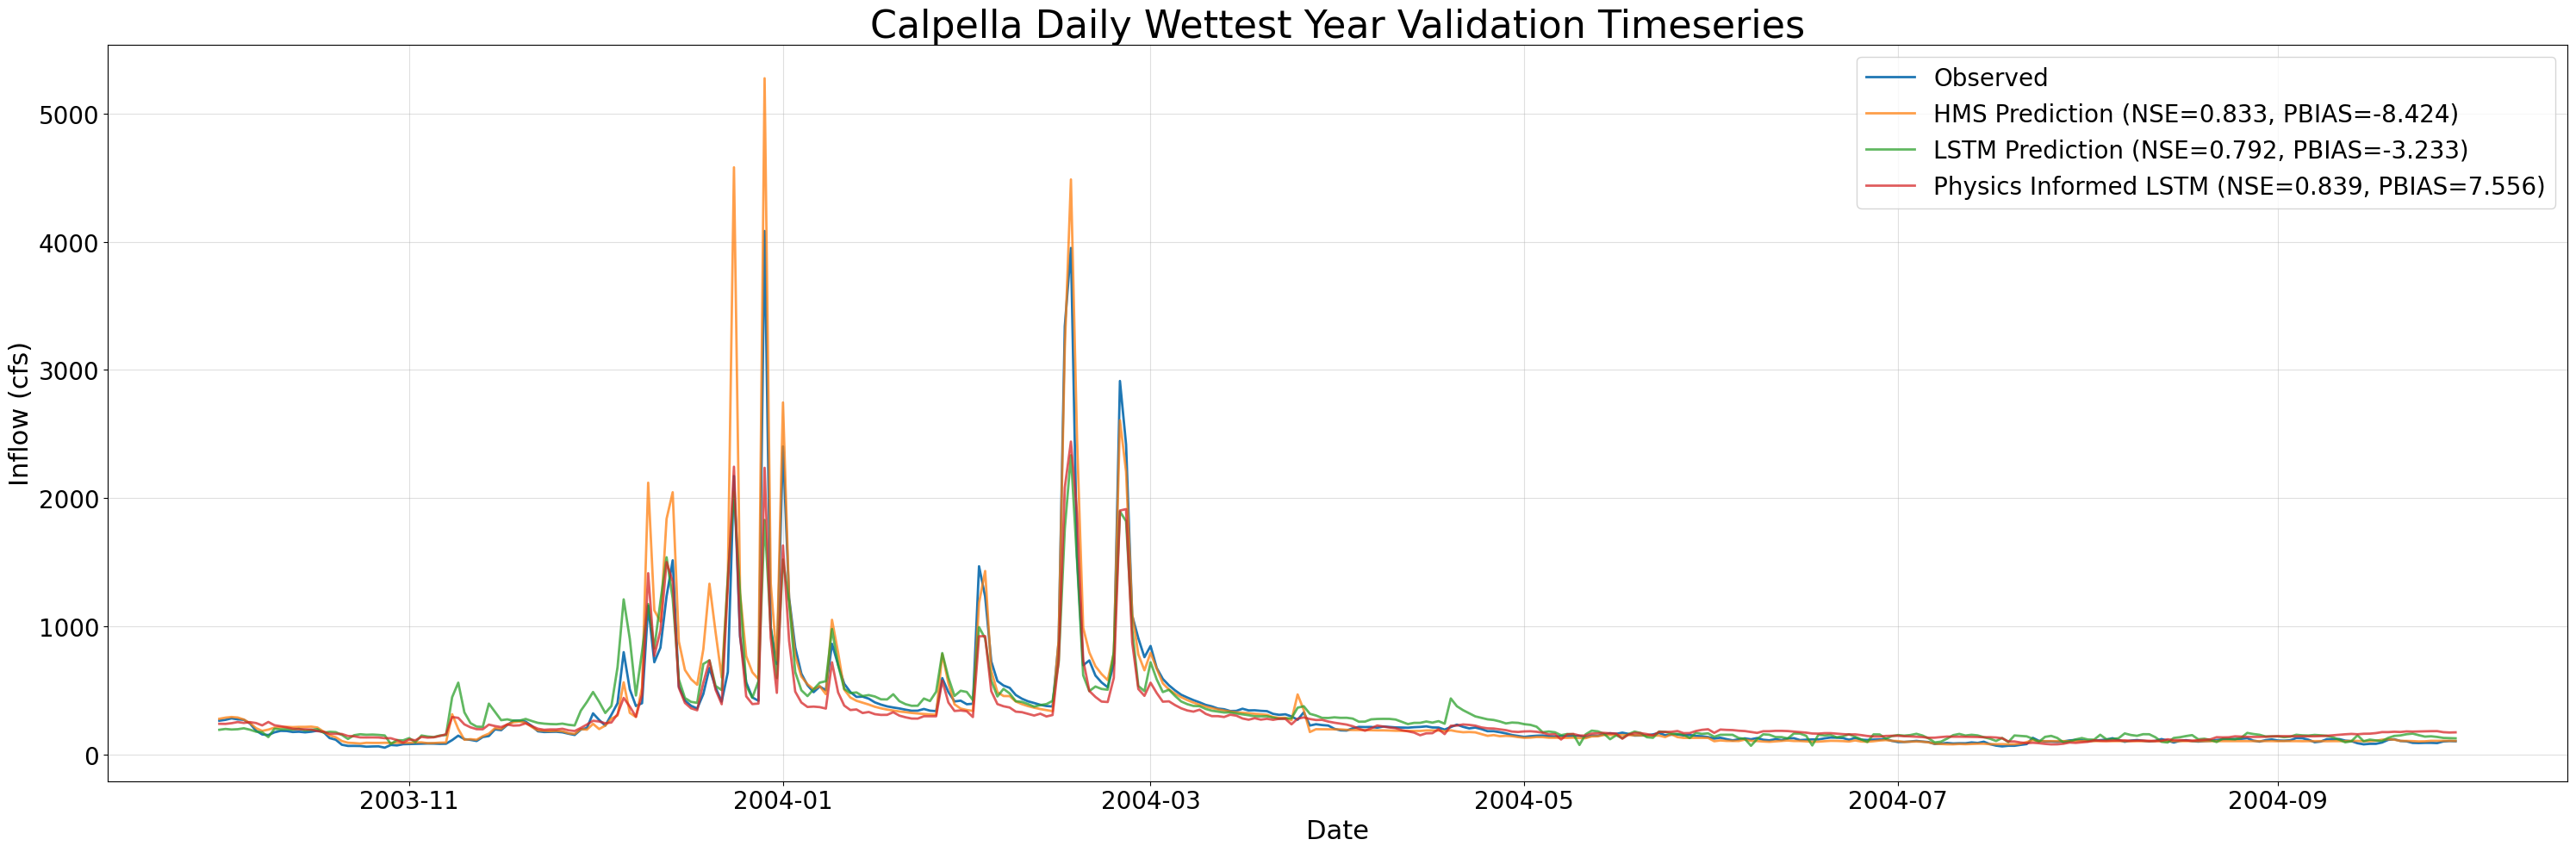

In [34]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Calpella Daily Wettest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_val, end_date=wettest_end_val, metrics_out="calpella_daily_val_wet_metrics.csv", ts_out="calpella_daily_val_wet_combined_ts.csv", fig_out="calpella_daily_val_wet_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Calpella Daily Wettest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_val, end_date=wettest_end_val, metrics_out="calpella_daily_val_wet_metrics.csv", ts_out="calpella_daily_val_wet_combined_ts.csv", fig_out="calpella_daily_val_wet_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.736
  PBIAS = -0.531
LSTM
  NSE = 0.662
  PBIAS = 27.670
PILSTM
  NSE = 0.727
  PBIAS = 17.432


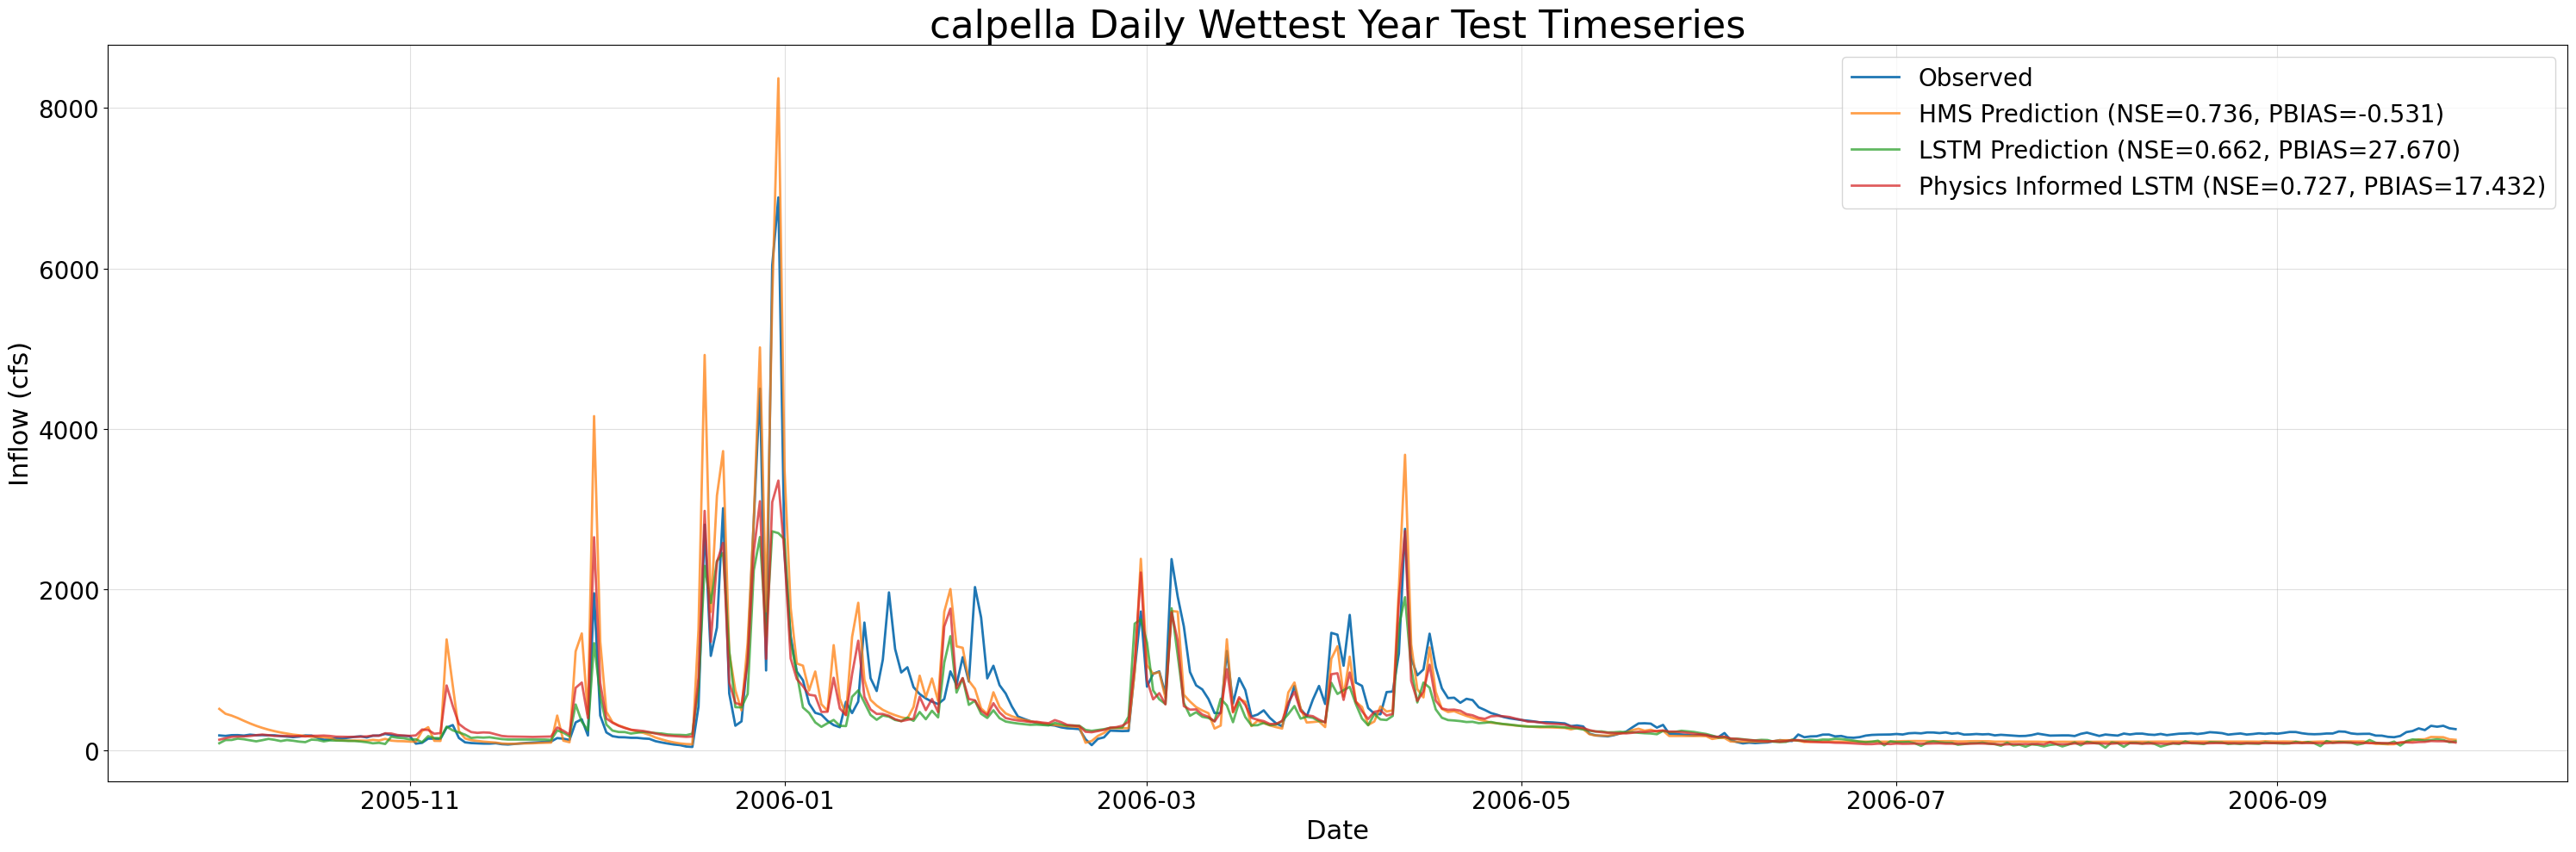

In [35]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="calpella Daily Wettest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="calpella_daily_test_wet_metrics.csv", ts_out="calpella_daily_test_wet_combined_ts.csv", fig_out="calpella_daily_test_wet_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="calpella Daily Wettest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="calpella_daily_test_wet_metrics.csv", ts_out="calpella_daily_test_wet_combined_ts.csv", fig_out="calpella_daily_test_wet_model_comparison.png", legend_font=20, axis_font=22)

In [36]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Wettest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="calpella_daily_test_wet_metrics.csv", ts_out="calpella_daily_test_wet_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Wettest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="calpella_daily_test_wet_metrics.csv", ts_out="calpella_daily_test_wet_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = 0.736
  PBIAS = -0.531
LSTM
  NSE = 0.662
  PBIAS = 27.670
PILSTM
  NSE = 0.727
  PBIAS = 17.432


##### Dryest Year Performance

HMS
  NSE = 0.931
  PBIAS = -2.703
LSTM
  NSE = 0.708
  PBIAS = -8.671
PILSTM
  NSE = 0.765
  PBIAS = 1.151


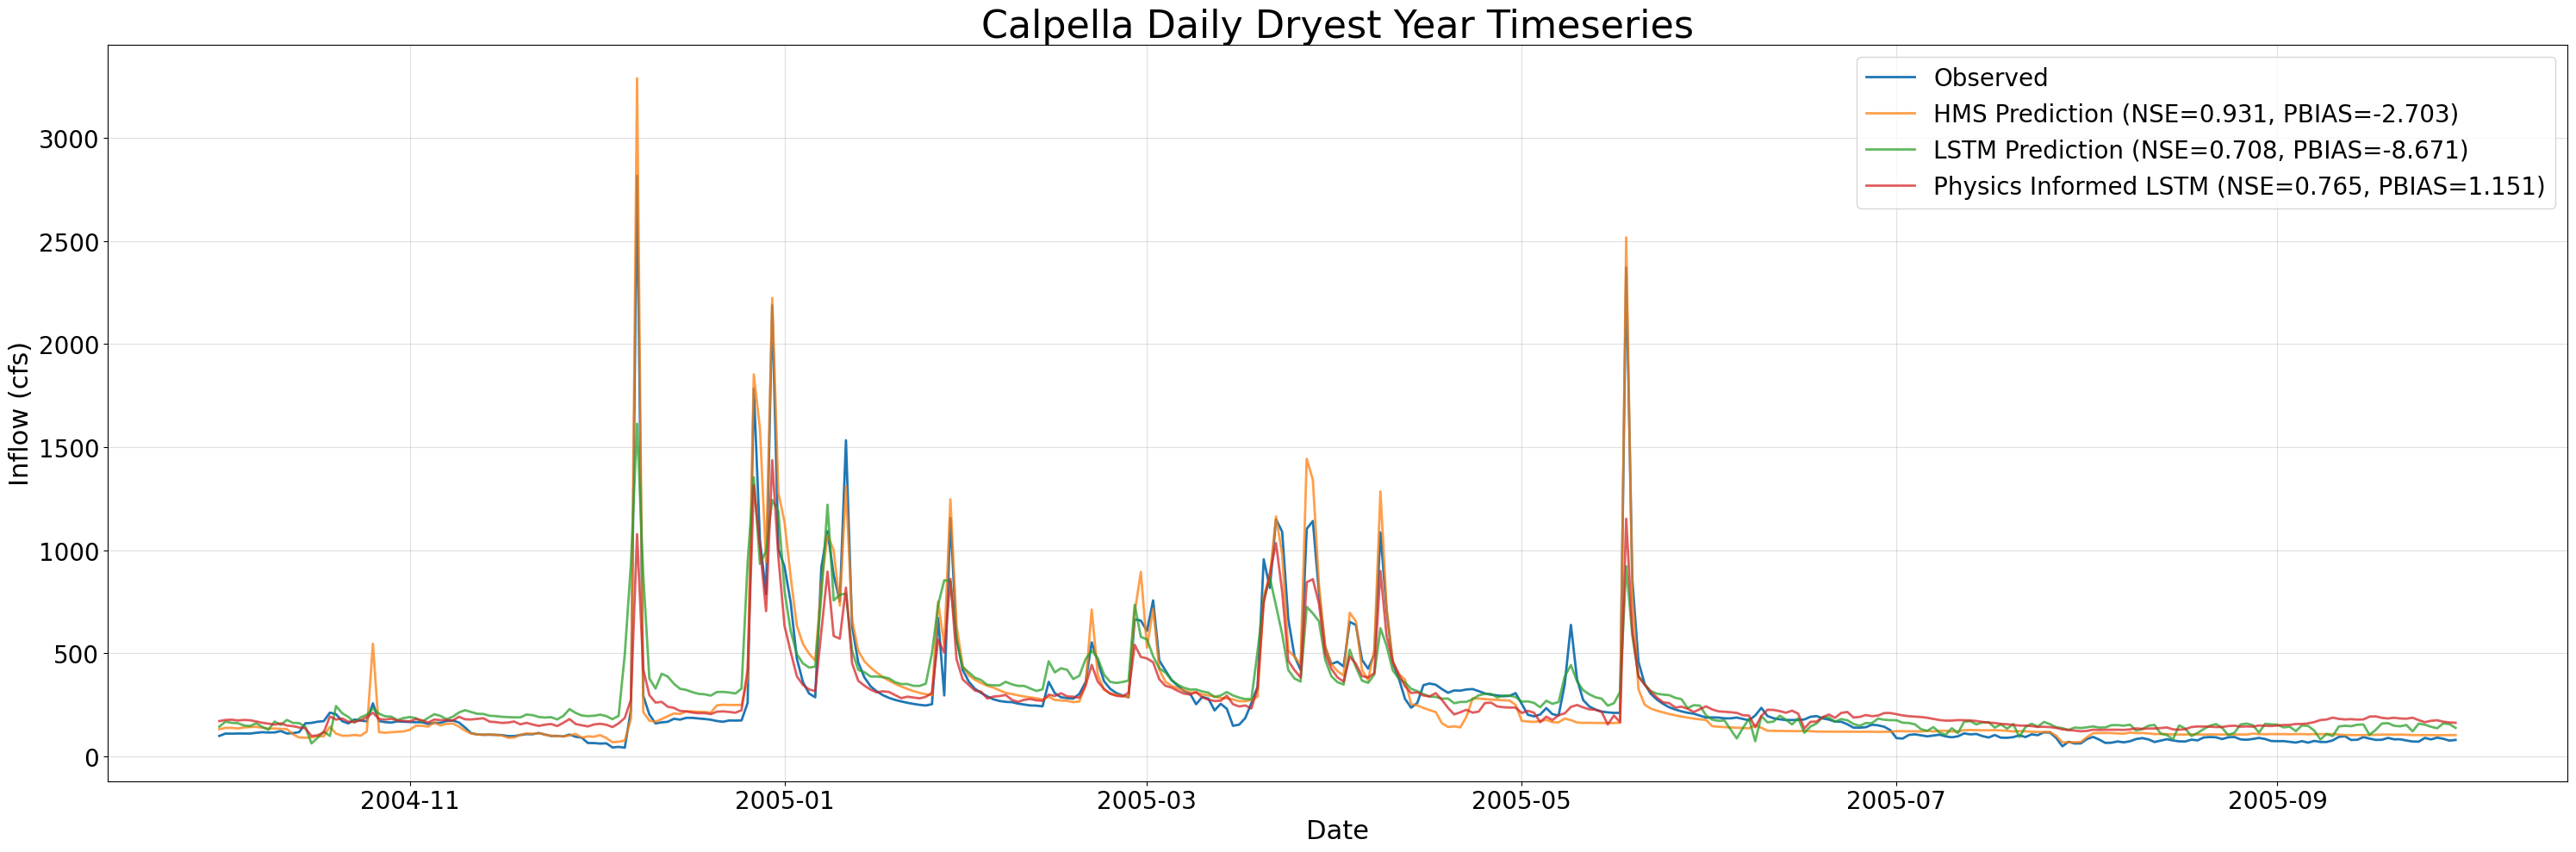

In [37]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Calpella Daily Dryest Year Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_val, end_date=dryest_end_val, metrics_out="calpella_daily_val_dry_metrics.csv", ts_out="calpella_daily_val_dry_combined_ts.csv", fig_out="calpella_daily_val_dry_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Calpella Daily Dryest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_val, end_date=dryest_end_val, metrics_out="calpella_daily_val_dry_metrics.csv", ts_out="calpella_daily_val_dry_combined_ts.csv", fig_out="calpella_daily_val_dry_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = -0.339
  PBIAS = -61.317
LSTM
  NSE = 0.199
  PBIAS = -111.480
PILSTM
  NSE = -0.004
  PBIAS = -116.438


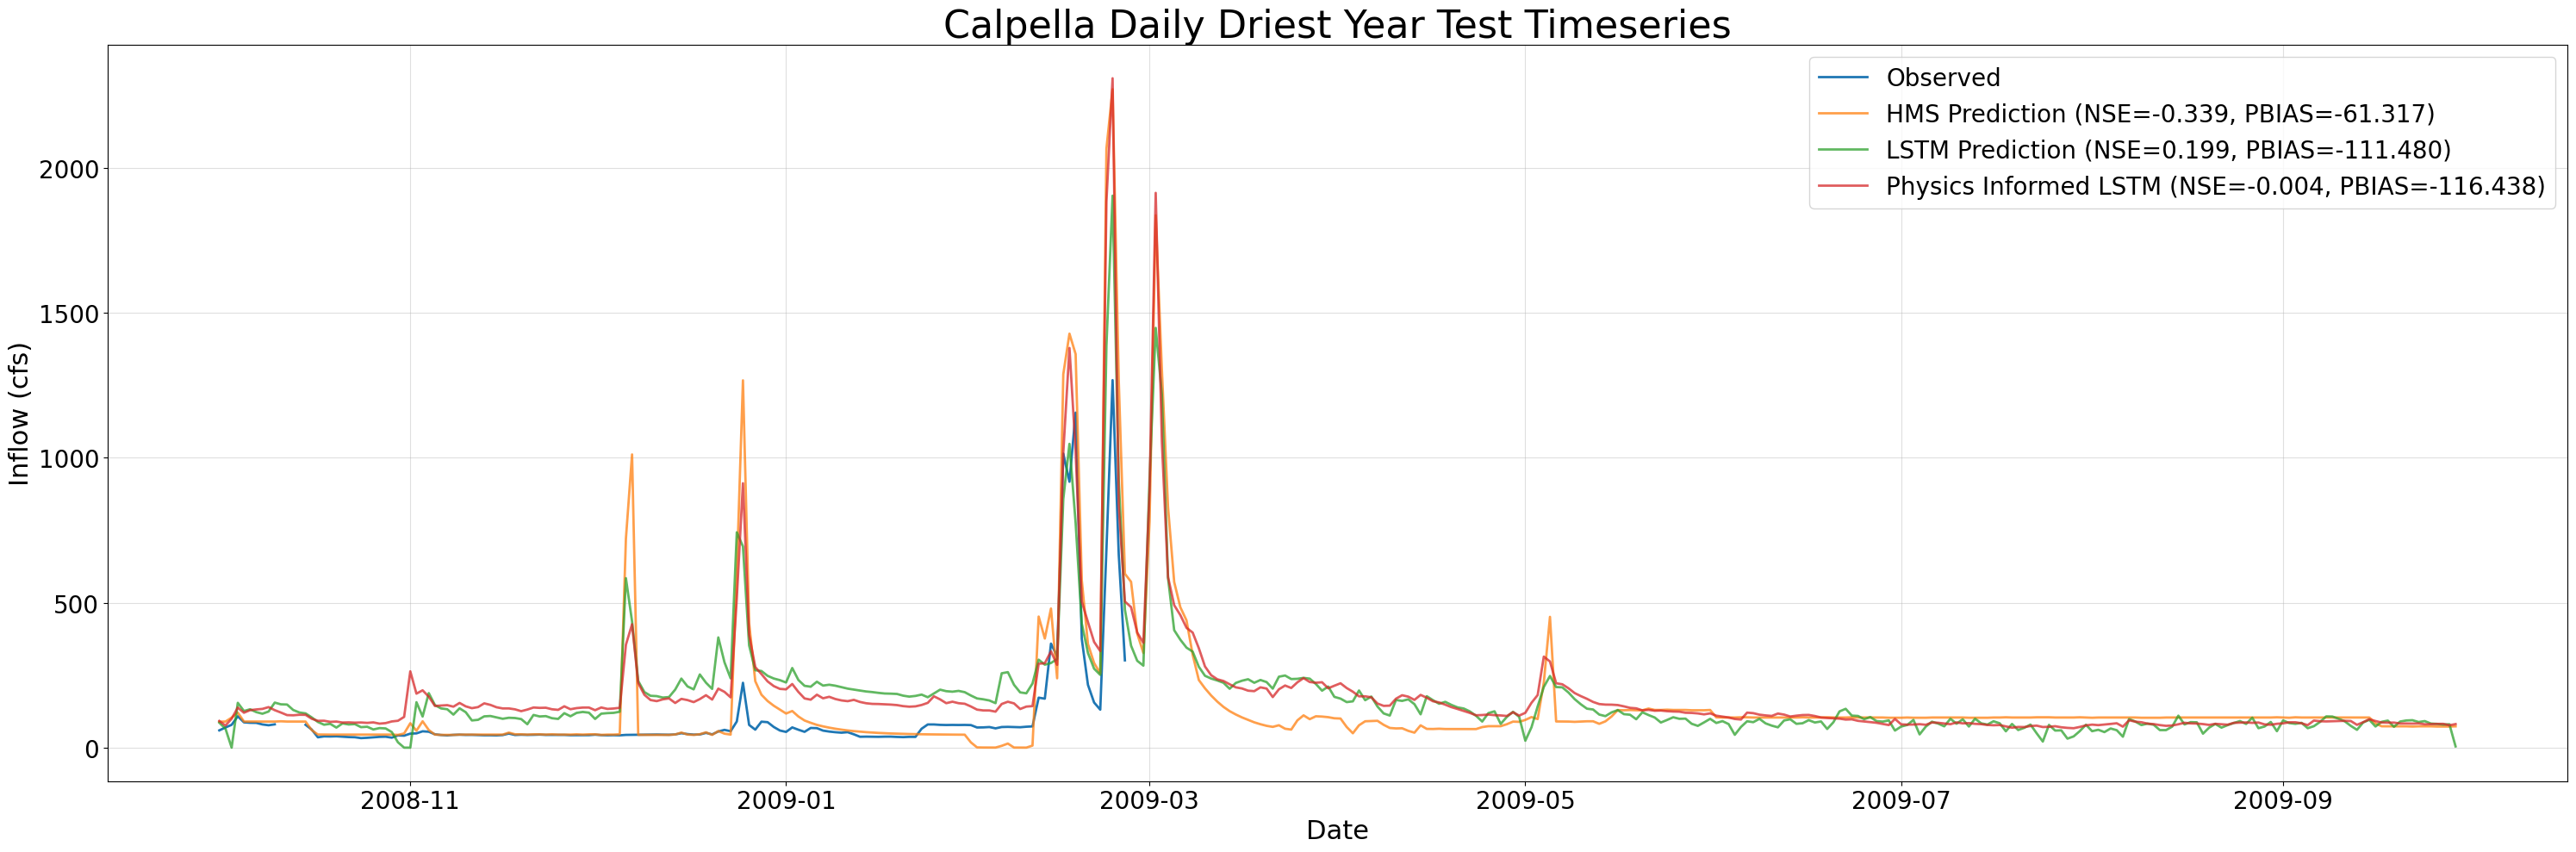

In [38]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Driest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="calpella_daily_test_dry_metrics.csv", ts_out="calpella_daily_test_dry_combined_ts.csv", fig_out="calpella_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Driest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="calpella_daily_test_dry_metrics.csv", ts_out="calpella_daily_test_dry_combined_ts.csv", fig_out="calpella_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)

In [39]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Driest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="calpella_daily_test_dry_metrics.csv", ts_out="calpella_daily_test_dry_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Driest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="calpella_daily_test_dry_metrics.csv", ts_out="calpella_daily_test_dry_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = -0.339
  PBIAS = -61.317
LSTM
  NSE = 0.199
  PBIAS = -111.480
PILSTM
  NSE = -0.004
  PBIAS = -116.438


##### Gridded Timeseries Plots - Validation and Testing

In [40]:
if not skip_best_model_validation:
    ts_triptych_v3((no_physics_val_csv, physics_val_csv, path_to_physics_data),wet_start=wettest_start_test, wet_end=wettest_end_test, dry_start=dryest_start_test, dry_end=dryest_end_test, save_path="calpella_daily_TS_validation.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d-%b-%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title="Calpella Daily Validation Period Timeseries Across Models", main_title_font=14, main_title_y=0.99, main_title_pad=0.05, row_titles=("Full Validation period","Most-wet water-year","Most-dry water-year"))
    
else:
    ts_triptych_v3(combined_df_val, wet_start=wettest_start_val, wet_end=wettest_end_val, dry_start=dryest_start_val, dry_end=dryest_end_val, save_path="calpella_daily_TS_validation.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d‑%b‑%Y", figsize=(10, 10), dpi=600, hspace=0.2,main_title = "Calpella Daily Validation Timeseries Across Models", main_title_font=14, main_title_y = 0.99, main_title_pad = 0.05, row_titles=("Full validation period", "Most‑wet water‑year", "Most‑dry water‑year"))

In [41]:
if not skip_best_model_test:
    ts_triptych_v3((no_physics_test_csv, physics_test_csv, path_to_physics_data), wet_start=wettest_start_test, wet_end=wettest_end_test,dry_start=dryest_start_test, dry_end=dryest_end_test, save_path="calpella_daily_TS_testing.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d-%b-%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title="Calpella Daily Test Period Timeseries Across Models", main_title_font=14, main_title_y=0.99, main_title_pad=0.05, row_titles=("Full Testing period","Most-wet water-year","Most-dry water-year"))

else:
    ts_triptych_v3(combined_df, wet_start=wettest_start_test, wet_end=wettest_end_test, dry_start=dryest_start_test, dry_end=dryest_end_test, save_path="calpella_daily_TS_testing.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d‑%b‑%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title = "Calpella Daily Test Period Timeseries Across Models", main_title_font=14, main_title_y = 0.99, main_title_pad = 0.05, row_titles=("Full Testing period", "Most‑wet water‑year", "Most‑dry water‑year"))

##### Gridded Scatter Plots - Testing

In [42]:
if not skip_best_model_test:
    scatter_triptych_pngs_v3((no_physics_test_csv, physics_test_csv, path_to_physics_data), wet_start=wettest_start_test, wet_end=wettest_end_test, dry_start=dryest_start_test, dry_end=dryest_end_test, out_dir="calpella_daily_scatter", layout="horizontal", square_side=4.5, legend_font=16, axis_font=16, point_size=28, top_pad=.90, suptitle_y=1.04, dpi=600, row_titles=("Calpella Daily – Full test period", "Calpella Daily – Wettest water-year", "Calpella Daily – Driest water-year"), resolution="daily")
else:
    scatter_pngs = scatter_triptych_pngs_v3(combined_df, wet_start = wettest_start_test, wet_end = wettest_end_test, dry_start = dryest_start_test,  dry_end = dryest_end_test, out_dir = "calpella_daily_scatter", layout = "horizontal", square_side  = 4.5, legend_font  = 16, axis_font = 16, point_size = 28, top_pad = .90, suptitle_y = 1.04, dpi = 600, row_titles = ("Calpella Daily – Full test period", "Calpella Daily – Wettest water‑year", "Calpella Daily – Driest water‑year"), resolution = "daily")